In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from fastai.vision import *
from fastai.callbacks import *
from fastai.widgets import *

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
flg_grey = True

def get_data(sz, bs):

    tfms = get_transforms(do_flip=True,flip_vert=False ,max_rotate=0.0, max_zoom=1.22, max_lighting=0.22, max_warp=0.0, p_affine=0.75,
                          p_lighting=0.75,xtra_tfms=zoom_crop(scale=(0.7,1.4), do_rand=True, p=0.6))
    #, xtra_tfms=zoom_crop(scale=(0.9,1.8), do_rand=True, p=0.8))



    src = (ImageList.from_df(train_df, path='/kaggle//input/Dance_DS', folder='train')
           .split_by_rand_pct(0.20) #split_none() 
           .label_from_df()
           .add_test_folder('test'))
    
    data = (src.transform(tfms, size=sz,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=bs, device= torch.device('cuda:0')).normalize(imagenet_stats))
    
    if flg_grey:
        for itemList in ["train_dl", "valid_dl", "fix_dl", "test_dl"]:
            itemList = getattr(data, itemList)
            if itemList: itemList.x.convert_mode = "L"
    
    return data

In [3]:
train_df = pd.read_csv(  '/kaggle//input/Dance_DS/train.csv')

In [4]:
round(train_df.target.value_counts()/train_df.shape[0]*100)

#Can duplicate Manipuri a bit

mohiniyattam     14.0
odissi           13.0
bharatanatyam    13.0
kathakali        13.0
kuchipudi        13.0
sattriya         12.0
kathak           12.0
manipuri         10.0
Name: target, dtype: float64

In [5]:
df_final =  pd.DataFrame()

# iterate over each group
for group_name, df_group in train_df.groupby('target'):
    frac= 1.3 if group_name=="manipuri" else 1
    df_final=df_final.append(df_group)
    df_final=df_final.append(df_group.sample(frac=frac, random_state=0, replace = True))

train_df= df_final
print(train_df.shape)

train_df.groupby(['target']).size()/train_df.shape[0]*100

(739, 2)


target
bharatanatyam    12.719892
kathak           11.907984
kathakali        12.719892
kuchipudi        12.449256
manipuri         11.231394
mohiniyattam     13.531800
odissi           13.261164
sattriya         12.178620
dtype: float64

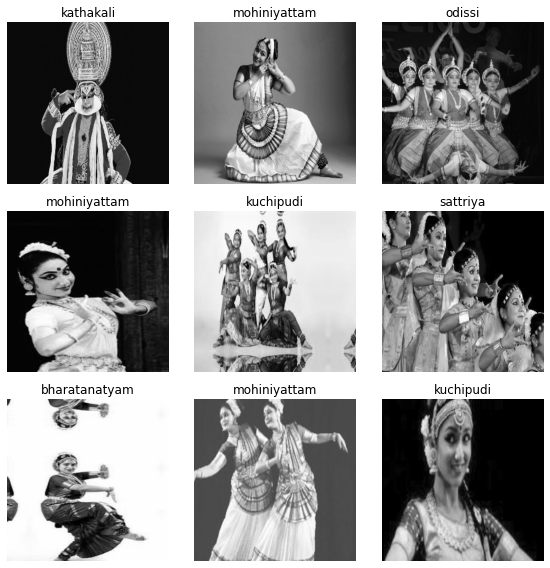

In [6]:
np.random.seed(60)
torch.manual_seed(60) # cpu  vars


data=get_data(299,16)
data.show_batch(rows=3, figsize=(8,8))

In [7]:
 torch.cuda.empty_cache() 

In [8]:
 data.c, len(data.train_ds), len(data.test_ds),len(data.valid_ds)

(8, 592, 156, 147)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 2.09E-02


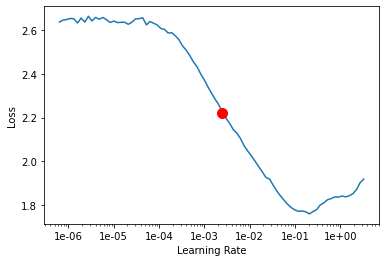

In [9]:
#lets create learner. tried with resnet152, densenet201, resnet101
mod_name='stage1_model'
learn = cnn_learner(data=data, base_arch=models.resnet152,bn_final=True, metrics= error_rate,callback_fns=ShowGraph)
#lets find the correct learning rate to be used from lr finder
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,1.605915,0.834382,0.292517,00:19
1,1.204805,0.523434,0.156463,00:19
2,1.027616,0.499528,0.115646,00:17
3,0.889759,0.465584,0.074830,00:18
4,0.800533,0.409894,0.081633,00:19
5,0.691754,0.308049,0.061224,00:18
6,0.588279,0.262072,0.061224,00:18
7,0.540120,0.258154,0.047619,00:19
8,0.517302,0.231031,0.054422,00:18
9,0.464691,0.277264,0.054422,00:18


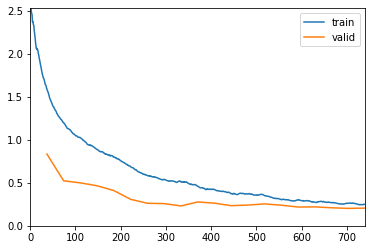

Better model found at epoch 0 with valid_loss value: 0.834381639957428.
Better model found at epoch 1 with valid_loss value: 0.5234337449073792.
Better model found at epoch 2 with valid_loss value: 0.49952811002731323.
Better model found at epoch 3 with valid_loss value: 0.4655838906764984.
Better model found at epoch 4 with valid_loss value: 0.4098943769931793.
Better model found at epoch 5 with valid_loss value: 0.30804866552352905.
Better model found at epoch 6 with valid_loss value: 0.26207175850868225.
Better model found at epoch 7 with valid_loss value: 0.2581535577774048.
Better model found at epoch 8 with valid_loss value: 0.23103129863739014.
Better model found at epoch 15 with valid_loss value: 0.21843062341213226.
Better model found at epoch 17 with valid_loss value: 0.20978811383247375.
Better model found at epoch 18 with valid_loss value: 0.2025567591190338.


In [10]:
lr = 7e-3
learn.fit_one_cycle(20,wd=0.15, max_lr =slice(lr),callbacks=[SaveModelCallback(learn,monitor='valid_loss',mode='min',every='improvement',name=mod_name)]) 
#learn.fit_one_cycle(15,wd=0.15, max_lr =slice(lr),callbacks=[SaveModelCallback(learn,monitor='error_rate',mode='min',every='improvement',name=mod_name)]) 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.32E-07


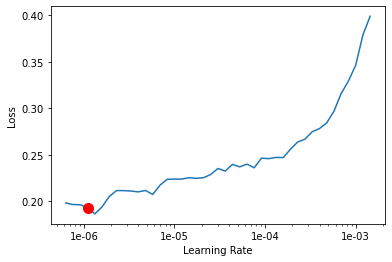

In [11]:
#lets plot the lr finder record
learn.unfreeze()

learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,0.247456,0.210949,0.047619,00:20
1,0.256234,0.198137,0.047619,00:21
2,0.249636,0.201674,0.054422,00:21
3,0.270486,0.214009,0.054422,00:20
4,0.257357,0.217050,0.027211,00:20
5,0.279940,0.194117,0.034014,00:20
6,0.267933,0.194605,0.027211,00:20
7,0.268827,0.192732,0.040816,00:21
8,0.280639,0.183493,0.040816,00:20
9,0.259187,0.176454,0.027211,00:20


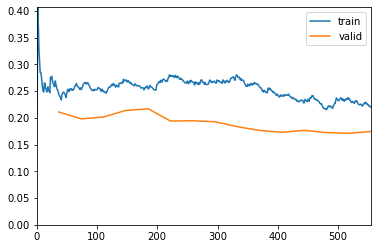

Better model found at epoch 0 with valid_loss value: 0.21094933152198792.
Better model found at epoch 1 with valid_loss value: 0.1981373429298401.
Better model found at epoch 5 with valid_loss value: 0.1941174864768982.
Better model found at epoch 7 with valid_loss value: 0.1927315592765808.
Better model found at epoch 8 with valid_loss value: 0.1834934651851654.
Better model found at epoch 9 with valid_loss value: 0.17645440995693207.
Better model found at epoch 10 with valid_loss value: 0.17305216193199158.
Better model found at epoch 12 with valid_loss value: 0.17242546379566193.
Better model found at epoch 13 with valid_loss value: 0.17118051648139954.


In [12]:
learn.fit_one_cycle(15, max_lr =slice(1.2e-6,lr/12),wd=0.1,callbacks=[SaveModelCallback(learn,monitor='valid_loss',mode='min',every='improvement',name=mod_name)])   

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.37E-06


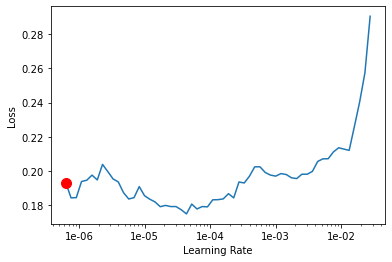

In [13]:
data=get_data(399,16)
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,0.243339,0.167576,0.027211,00:18
1,0.217108,0.168542,0.034014,00:17
2,0.209049,0.168285,0.034014,00:17
3,0.206145,0.169612,0.034014,00:18
4,0.201977,0.166442,0.034014,00:17
5,0.189696,0.166591,0.034014,00:17
6,0.197970,0.168043,0.034014,00:17
7,0.205765,0.167726,0.034014,00:18


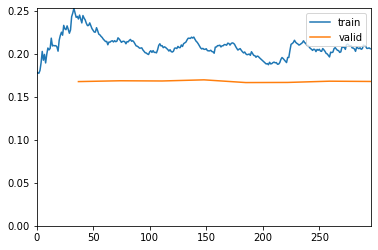

Better model found at epoch 0 with valid_loss value: 0.16757634282112122.
Better model found at epoch 4 with valid_loss value: 0.166442409157753.


In [14]:
learn.fit_one_cycle(8, max_lr =slice(7e-7,lr/20),wd=0.10,callbacks=[SaveModelCallback(learn,monitor='valid_loss',mode='min',every='improvement',name=mod_name)])   

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=1)

[('bharatanatyam', 'mohiniyattam', 2),
 ('kuchipudi', 'mohiniyattam', 1),
 ('mohiniyattam', 'bharatanatyam', 1),
 ('mohiniyattam', 'manipuri', 1),
 ('odissi', 'kuchipudi', 1)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


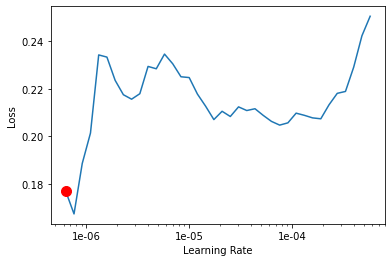

In [16]:
#lets plot the lr finder record
learn.unfreeze()

learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,0.198614,0.168033,0.040816,00:20
1,0.212277,0.161293,0.027211,00:21
2,0.232087,0.162309,0.047619,00:21
3,0.203958,0.170508,0.034014,00:19
4,0.221525,0.164058,0.034014,00:20
5,0.209607,0.167095,0.034014,00:20
6,0.203865,0.164363,0.034014,00:19
7,0.223954,0.162440,0.034014,00:20


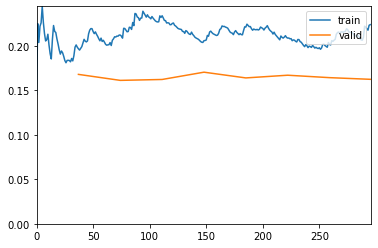

Better model found at epoch 0 with valid_loss value: 0.1680334508419037.
Better model found at epoch 1 with valid_loss value: 0.1612929254770279.


In [17]:
learn.fit_one_cycle(8, max_lr =slice(7e-7),wd=0.05,callbacks=[SaveModelCallback(learn,monitor='valid_loss',mode='min',every='improvement',name=mod_name)])   

In [18]:
learn.freeze_to(-10)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.02E-06


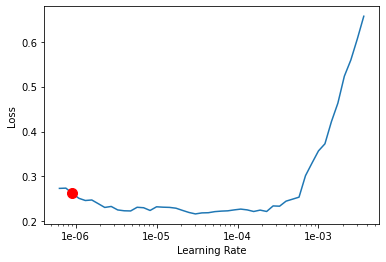

In [19]:
#lets plot the lr finder record

learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,0.210016,0.164287,0.040816,00:20
1,0.216376,0.176086,0.040816,00:19
2,0.219392,0.180281,0.040816,00:21
3,0.227955,0.177104,0.054422,00:19
4,0.208207,0.179775,0.034014,00:20
5,0.216064,0.170164,0.040816,00:20


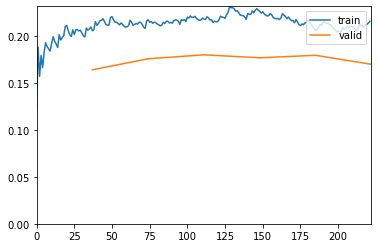

In [20]:
# train for  more cycles after unfreezing
learn.fit_one_cycle(6, slice(7e-07, lr/10),wd=0.05)

In [21]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.32E-07


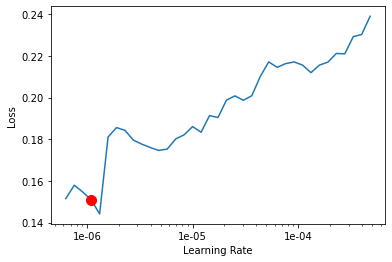

In [22]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.save('/kaggle/working/stage1_model')

epoch,train_loss,valid_loss,error_rate,time
0,0.186668,0.180083,0.040816,00:20
1,0.166177,0.178581,0.040816,00:20
2,0.182495,0.172241,0.040816,00:20
3,0.198501,0.169822,0.034014,00:20
4,0.200697,0.170297,0.040816,00:20
5,0.192365,0.170496,0.034014,00:20
6,0.208284,0.169994,0.040816,00:20
7,0.196928,0.177051,0.040816,00:19


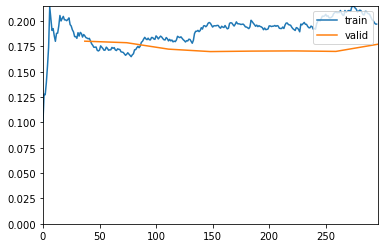

Better model found at epoch 0 with valid_loss value: 0.18008305132389069.
Better model found at epoch 1 with valid_loss value: 0.17858074605464935.
Better model found at epoch 2 with valid_loss value: 0.17224113643169403.
Better model found at epoch 3 with valid_loss value: 0.16982243955135345.


In [24]:
learn.fit_one_cycle(8,max_lr= slice(2e-6),wd=0.05,callbacks=[SaveModelCallback(learn,monitor='valid_loss',mode='min',every='improvement',name=mod_name)])   

In [25]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 9.12E-08


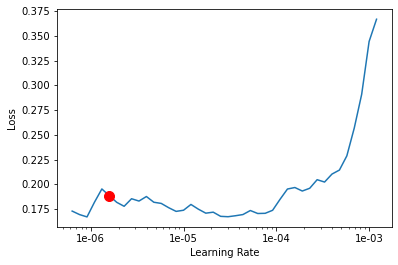

In [26]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,0.191407,0.166223,0.040816,00:19
1,0.206329,0.202866,0.040816,00:19
2,0.224818,0.185627,0.040816,00:20
3,0.243390,0.208275,0.054422,00:19
4,0.232010,0.181142,0.034014,00:19
5,0.225368,0.195984,0.054422,00:19
6,0.213380,0.182153,0.047619,00:19
7,0.209389,0.183503,0.034014,00:19


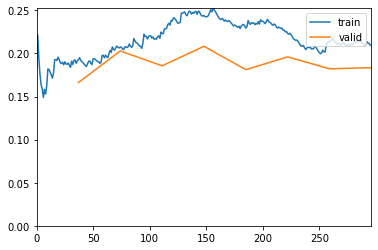

Better model found at epoch 0 with valid_loss value: 0.16622333228588104.


In [27]:
learn.fit_one_cycle(8, slice(3e-06, lr/10),wd=0.1,callbacks=[SaveModelCallback(learn,monitor='valid_loss',mode='min',every='improvement',name=mod_name)])   

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=1)

[('bharatanatyam', 'kuchipudi', 2),
 ('kuchipudi', 'mohiniyattam', 1),
 ('mohiniyattam', 'bharatanatyam', 1),
 ('mohiniyattam', 'manipuri', 1),
 ('odissi', 'kuchipudi', 1)]

In [29]:
learn.export()
fnames = [str(x)[str(x).rfind('/')+1:] for x in data.test_ds.items[:]]

In [32]:
#preds, _ = learn.get_preds(ds_type=DatasetType.Test)  
preds, _ = learn.TTA(ds_type=DatasetType.Test) #TTA performs better

labels = np.argmax(preds, 1)
test_predictions_direct = [data.classes[int(x)] for x in labels]

In [33]:
df_final = pd.DataFrame(list(zip(fnames, test_predictions_direct)),  columns =['Image', 'target']) 
df_final.to_csv('/kaggle/working/submission.csv', index=False)